#### ИНИЦИАЛИЗАЦИЯ

In [285]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [286]:
try:
    font_path = "/home/nekkon/my_fonts/tilda-sans_medium.ttf"

    fm.fontManager.addfont(font_path)
    font_name = fm.FontProperties(fname=font_path).get_name()

    sns.set_theme(style="whitegrid", context="talk")

    plt.rcParams.update({
        "font.family": font_name,
        "font.weight": "medium",
        "axes.labelweight": "medium",
        "axes.titleweight": "medium",
        "axes.labelsize": 24,
        "axes.titlesize": 28,
        "figure.facecolor": "#F6F6F6",
        "axes.facecolor": "#F6F6F6",
        "savefig.format": "png",
    })

    font_prop = fm.FontProperties(fname=font_path)

    font_prop
    print('tilda-sans')
except Exception:
    font_prop = fm.FontProperties(family='DejaVu Sans') 
    print('Щрифт не найден, используется DejaVu Sans')
    font_name = font_prop.get_name()

Щрифт не найден, используется DejaVu Sans


In [287]:
flats = pd.read_csv('../data/flats.csv')
deals = pd.read_csv('../data/deals.csv')

In [288]:
df = deals.copy()
df['Дата ввода в эксплуатацию'] = pd.to_datetime(df['Дата ввода в эксплуатацию'])
df['Плановая дата РВЭ'] = pd.to_datetime(df['Плановая дата РВЭ'])
df['Дата договора (месяц.год)'] = pd.to_datetime(df['Дата договора (месяц.год)'])
df['Дата начала продаж'] = pd.to_datetime(df['Дата начала продаж'])

df['Дней после начала продаж'] = (df['Дата договора (месяц.год)'] - df['Дата начала продаж']).dt.days
df['Дней до ввода в эксплуатацию'] = (df['Дата ввода в эксплуатацию'] - df['Дата договора (месяц.год)']).dt.days
df['Дней между началом продаж и вводом в эксплуатацию'] = (df['Дата ввода в эксплуатацию'] - df['Дата начала продаж']).dt.days

df = df.sort_values(by='Дата договора (месяц.год)')
# ВНИМАНИЕ! Мы все считаем верно. В ходе длинного анализа сайтов застройщика и разговоров с экспертом мы поняли как счиатть верно
# Если корпус введен в эксплуатацию, то 'Плановая дата РВЭ' является фактической датой получения РВЭ
# А 'Дата ввода в эксплуатацию' это дата, которую пообещали при продаже квартиры
# Мы вычитаем из фактической даты РВЭ самую первую дату-обещания
df['Задержка в днях'] = (
    df['Плановая дата РВЭ'] -
    df.groupby('ID корпуса')['Дата ввода в эксплуатацию'].transform('first')
).dt.days
df['Задержка'] = df['Задержка в днях'] > 0
df['Сдача в срок'] = df['Задержка в днях'] == 0
df['Ранняя сдача'] = df['Задержка в днях'] < 0

df['Площадь квартиры'] = df['Суммарная площадь сделок'] / df['Суммарное количество сделок'].replace(0, np.nan)

df['Уступка'] = df['Уступка'].apply(lambda val: val if isinstance(val, bool) else val == 'Договор уступки')

result = df.groupby('ID корпуса').agg(
    total=('Уступка', 'size'),
    assignments=('Уступка', 'sum')
)

assignment_rates = (
    df.groupby('Название ЖК')
    .agg(
        total=('Уступка', 'size'),
        assignments=('Уступка', 'sum')
    )
    .reset_index()
)

assignment_rates['Доля уступок'] = (assignment_rates['assignments'] / assignment_rates['total']) * 100

df = pd.merge(
    df,
    assignment_rates[['Название ЖК', 'Доля уступок']],
    on='Название ЖК',
    how='left'
)

In [289]:
def print_stats(data):
    print(f'Медиана: {data.median()}, Среднее: {data.mean()}, Ст. отклонение: {data.std()}')

ФИЛЬТРАЦИЯ

In [290]:
def filter(df, condition):
    prev = len(df)
    df = df[condition]
    print(len(df) / prev)
    return df

print('Before:', len(df))
df = filter(df, df['Суммарное количество сделок'] == 1) 

Before: 50955
0.9877931508193504


In [291]:
len(df[df['Площадь квартиры'] == 0])

836

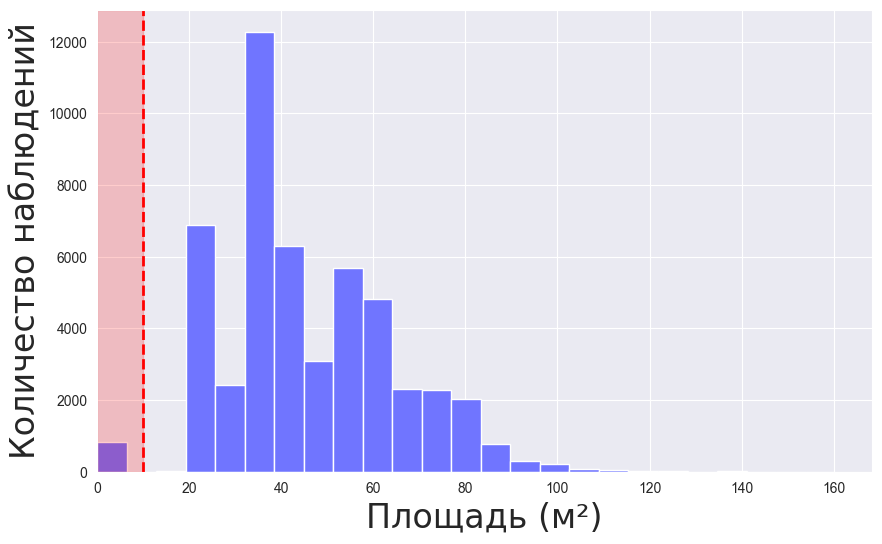

Медиана: 40.39, Среднее: 45.3586700574176, Ст. отклонение: 18.774325335465672


In [292]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    x=df['Площадь квартиры'].dropna(), 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

ax.axvline(x=10, color='red', linestyle='--', linewidth=2)
ax.axvspan(xmin=0, xmax=10, color='red', alpha=0.2)
ax.set_xlim(left=0) 

plt.xlabel('Площадь (м²)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)
plt.savefig('../graphs/avg_lot_area_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(df['Площадь квартиры'].dropna())

ФИЛЬТРАЦИЯ

In [293]:
df = filter(df, df['Площадь квартиры'].notna() & (df['Площадь квартиры'] != 0))
print('After:', len(df))

0.9833906184809171
After: 49497


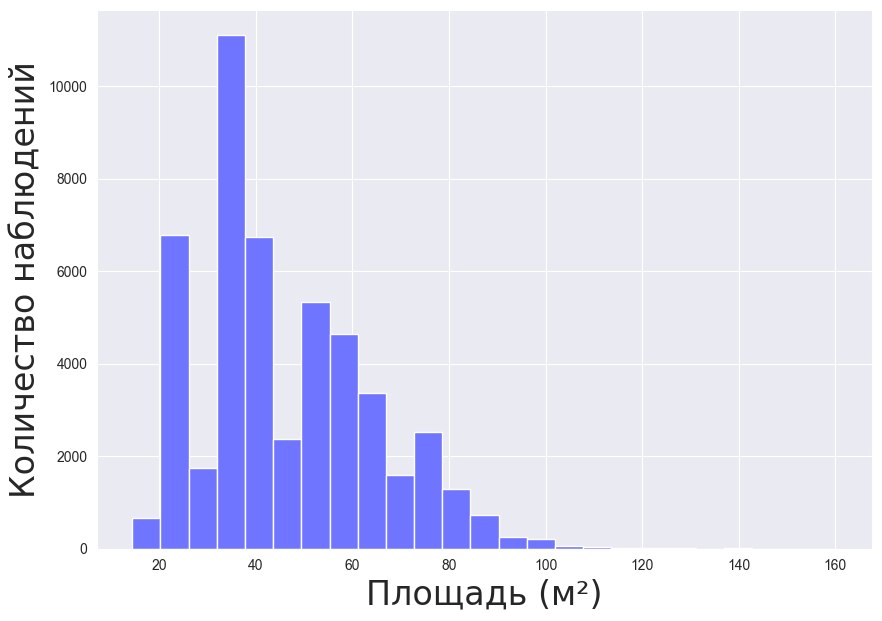

Медиана: 40.6, Среднее: 46.124774026708685, Ст. отклонение: 17.974749025661183


In [294]:
plt.figure(figsize=(10, 7))
ax = sns.histplot(
    x=df['Площадь квартиры'], 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Площадь (м²)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)
plt.savefig('../graphs/avg_lot_area_distribution_not_zero.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(df['Площадь квартиры'])

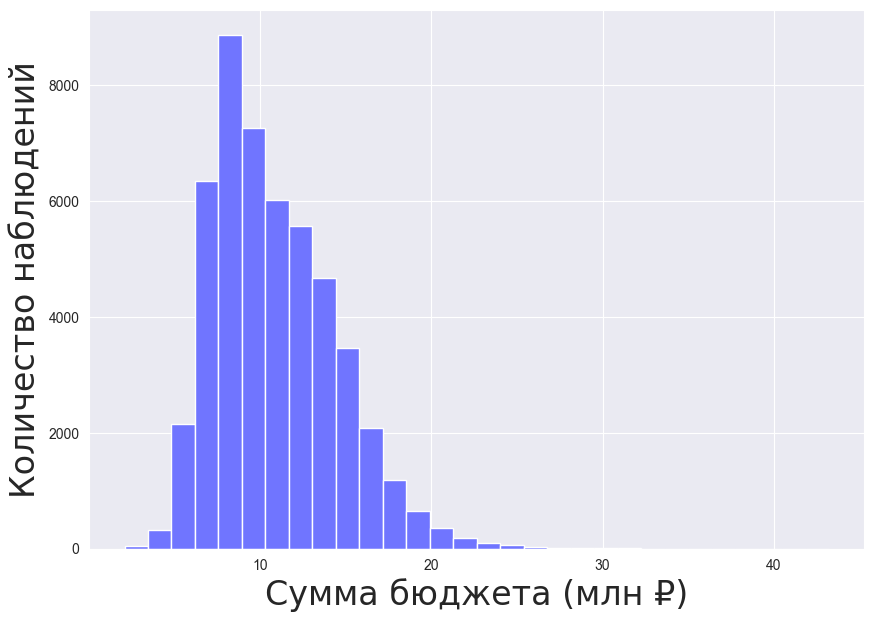

Медиана: 10.275581, Среднее: 10.895415343903267, Ст. отклонение: 3.6004079596903953


In [295]:
plt.figure(figsize=(10, 7))

x_data = df['Сумма бюджета'].dropna() / 1_000_000

ax = sns.histplot(
    x=x_data, 
    bins=30, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Сумма бюджета (млн ₽)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/budget_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

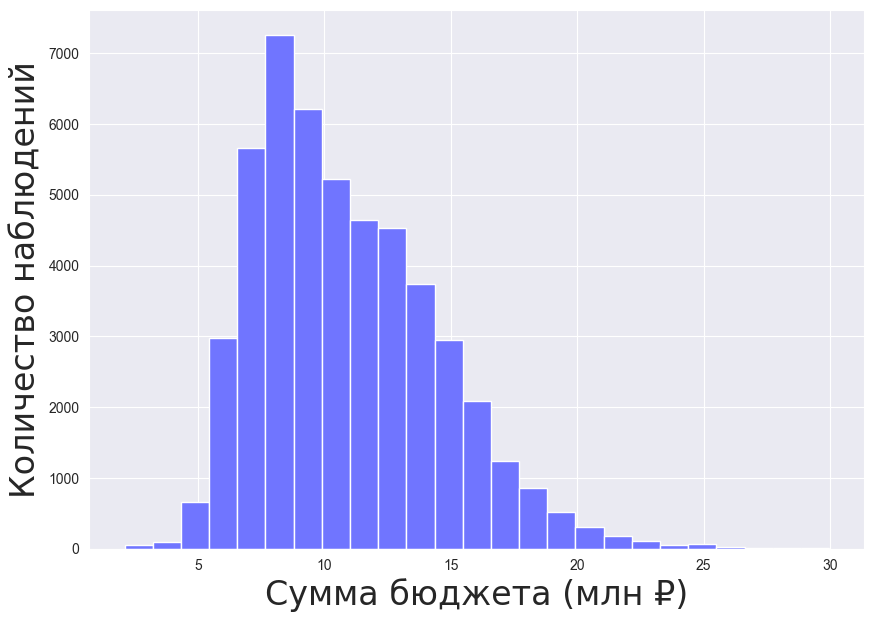

Медиана: 10.272857915, Среднее: 10.886879953279234, Ст. отклонение: 3.5740019817011914


In [296]:
plt.figure(figsize=(10, 7))

x_data = df[df['Сумма бюджета'] < 30000000]['Сумма бюджета'].dropna() / 1_000_000

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Сумма бюджета (млн ₽)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/budget_distribution_obrez.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

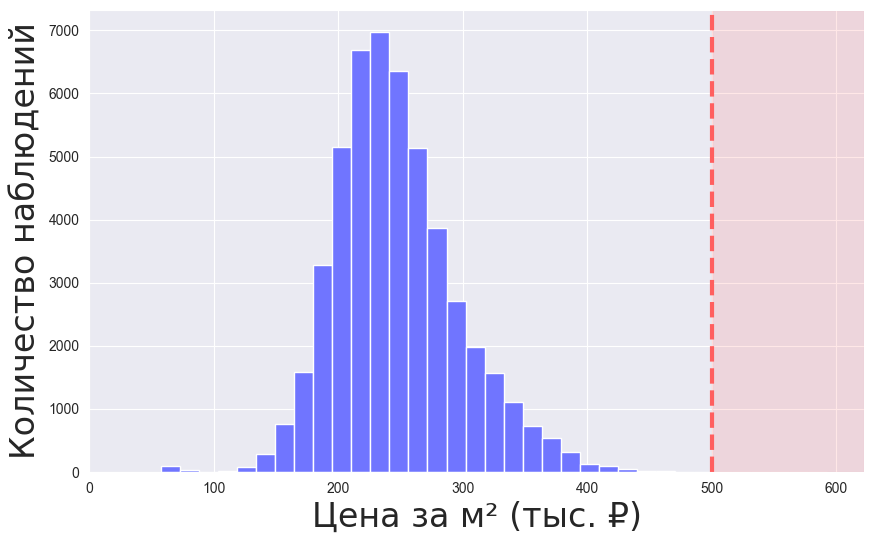

Медиана: 240.6, Среднее: 246.50449179461435, Ст. отклонение: 49.231317363676304


In [297]:
plt.figure(figsize=(10, 6))

x_data = df['Цена квадратного метра'].dropna() / 1000

ax = sns.histplot(
    x=x_data, 
    bins=35, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

ax.axvline(x=500, color='#ff5f5f', linestyle='--', linewidth=3)
ax.axvspan(xmin=500, xmax=x_data.max() * 1.05, color='#ff5f5f', alpha=0.15)

ax.set_xlim(left=0, right=x_data.max() * 1.05)

plt.xlabel('Цена за м² (тыс. ₽)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/price_sqm_distribution_limits.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

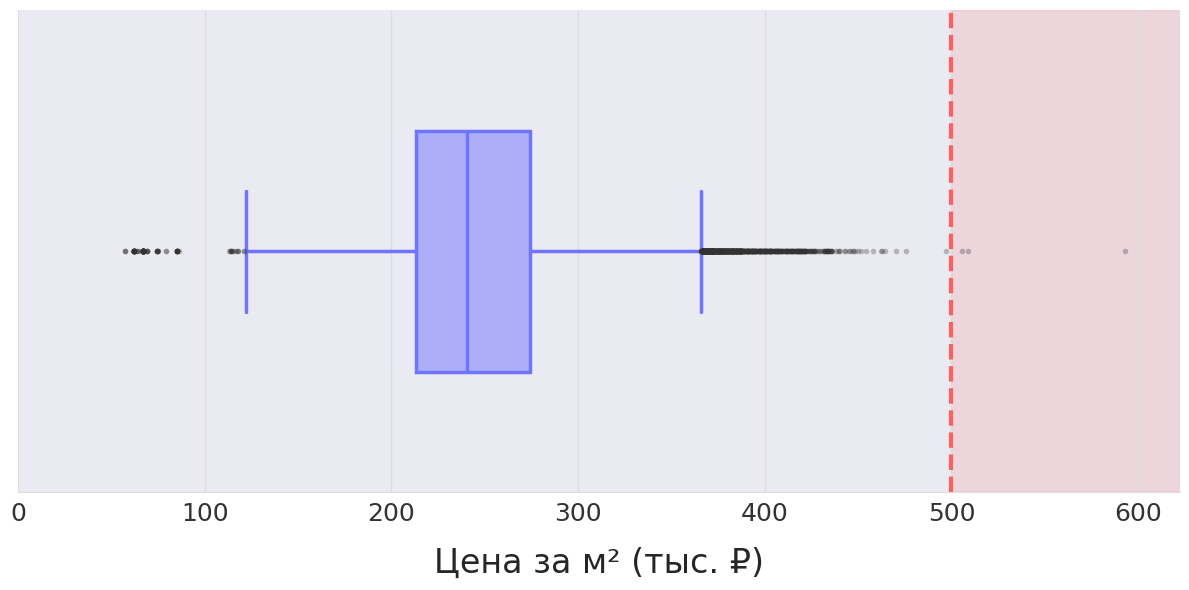

Медиана: 240.6, Среднее: 246.50449179461435, Ст. отклонение: 49.231317363676304


In [298]:
x_data = df['Цена квадратного метра'].dropna() / 1000
max_val = x_data.max() * 1.05

plt.figure(figsize=(12, 6))

box_facecolor = (112/255, 117/255, 255/255, 0.5)
line_color = '#7075FF'

flier_props = dict(
    marker='o', 
    markerfacecolor='#333333', 
    markersize=4,
    linestyle='none', 
    markeredgecolor='none', 
    alpha=0.3
)

median_props = dict(linestyle='-', linewidth=2.5, color=line_color)

ax = sns.boxplot(
    x=x_data, 
    flierprops=flier_props,
    boxprops=dict(facecolor=box_facecolor, edgecolor=line_color, linewidth=2.5),
    medianprops=median_props,
    whiskerprops=dict(color=line_color, linewidth=2.5),
    capprops=dict(color=line_color, linewidth=2.5),
    width=0.5
)

ax.axvline(x=500, color='#ff5f5f', linestyle='--', linewidth=3)
ax.axvspan(xmin=500, xmax=max_val, color='#ff5f5f', alpha=0.15, zorder=0)

ax.set_xlim(left=0, right=max_val)
ax.xaxis.grid(True, color='#dddddd', linestyle='-', linewidth=1)
ax.yaxis.grid(False)

sns.despine(left=True, bottom=False) 
ax.spines['bottom'].set_color('#dddddd')

plt.xlabel('Цена за м² (тыс. ₽)', fontproperties=font_prop, fontsize=24, labelpad=15)
plt.ylabel('', fontproperties=font_prop, fontsize=24)

for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
    label.set_color('#333333')

ax.set_yticks([])

plt.tight_layout()
plt.savefig('../graphs/price_sqm_boxplot_styled.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

ФИЛЬТРАЦИЯ

In [299]:
df = filter(df, df['Цена квадратного метра'] < 500_000)
print('After:', len(df))

0.9999393902660767
After: 49494


In [300]:
print_stats(df['Цена квадратного метра'].dropna() / 1000)

Медиана: 240.59309514040947, Среднее: 246.48695634945244, Ст. отклонение: 49.180257007058096


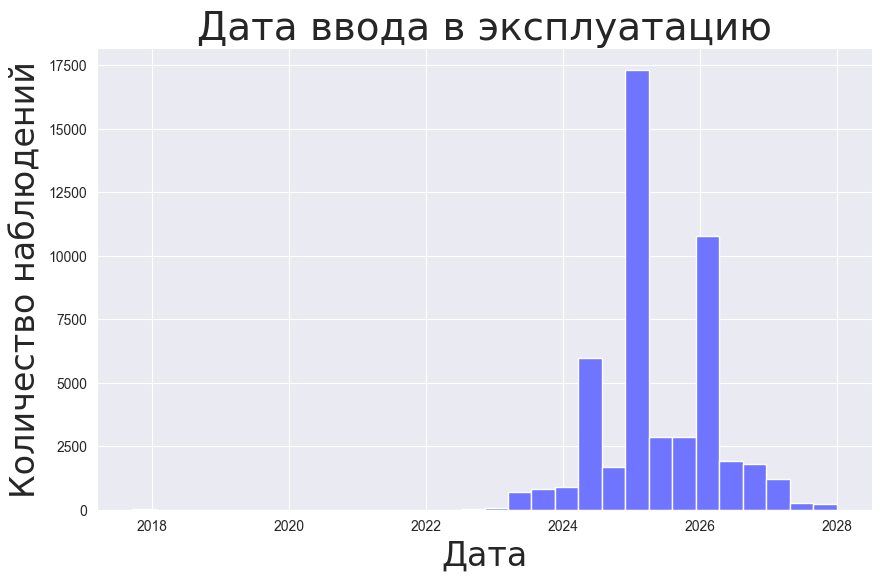

Медиана: 2025-03-31 00:00:00, Среднее: 2025-05-15 09:04:02.211176704, Ст. отклонение: 303 days 16:32:30.632593604


In [301]:
plt.figure(figsize=(10, 6))

x_data_actual = df['Дата ввода в эксплуатацию'].dropna()

sns.histplot(
    x=x_data_actual, 
    bins=30, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.title('Дата ввода в эксплуатацию', fontproperties=font_prop, fontsize=28)
plt.xlabel('Дата', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/date_actual_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data_actual)

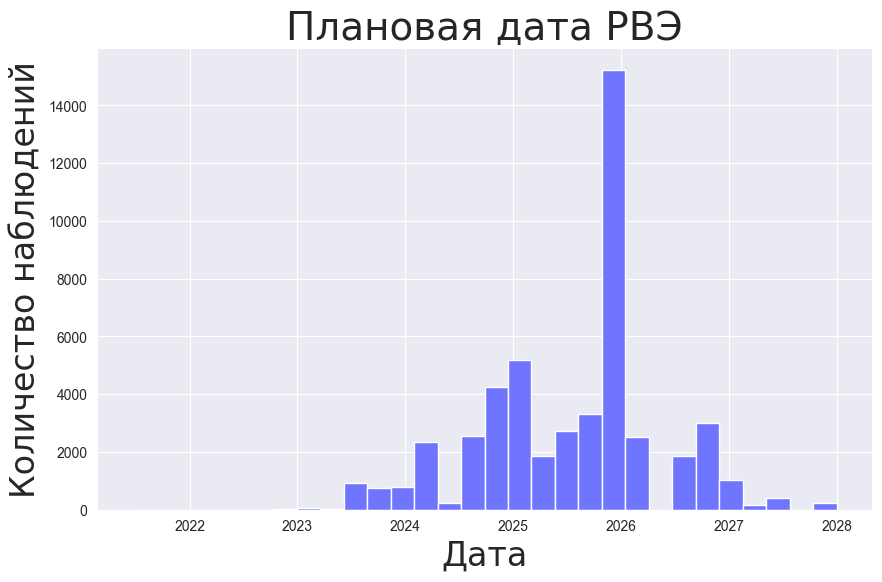

Медиана: 2025-03-31 00:00:00, Среднее: 2025-05-15 09:04:02.211176704, Ст. отклонение: 303 days 16:32:30.632593604


In [302]:
plt.figure(figsize=(10, 6))

x_data_plan = df['Плановая дата РВЭ'].dropna()

sns.histplot(
    x=x_data_plan, 
    bins=30, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.title('Плановая дата РВЭ', fontproperties=font_prop, fontsize=28)
plt.xlabel('Дата', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/date_planned_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data_actual)

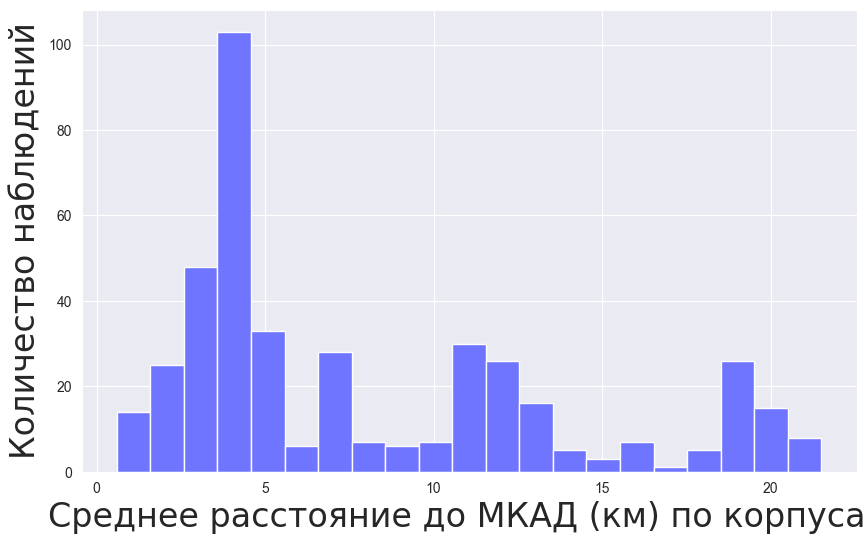

Медиана: 5.394, Среднее: 8.171422434367543, Ст. отклонение: 5.777037988381971


In [303]:
plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['Расстояние до МКАД'].mean().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=21, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Среднее расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/mkad_dist_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

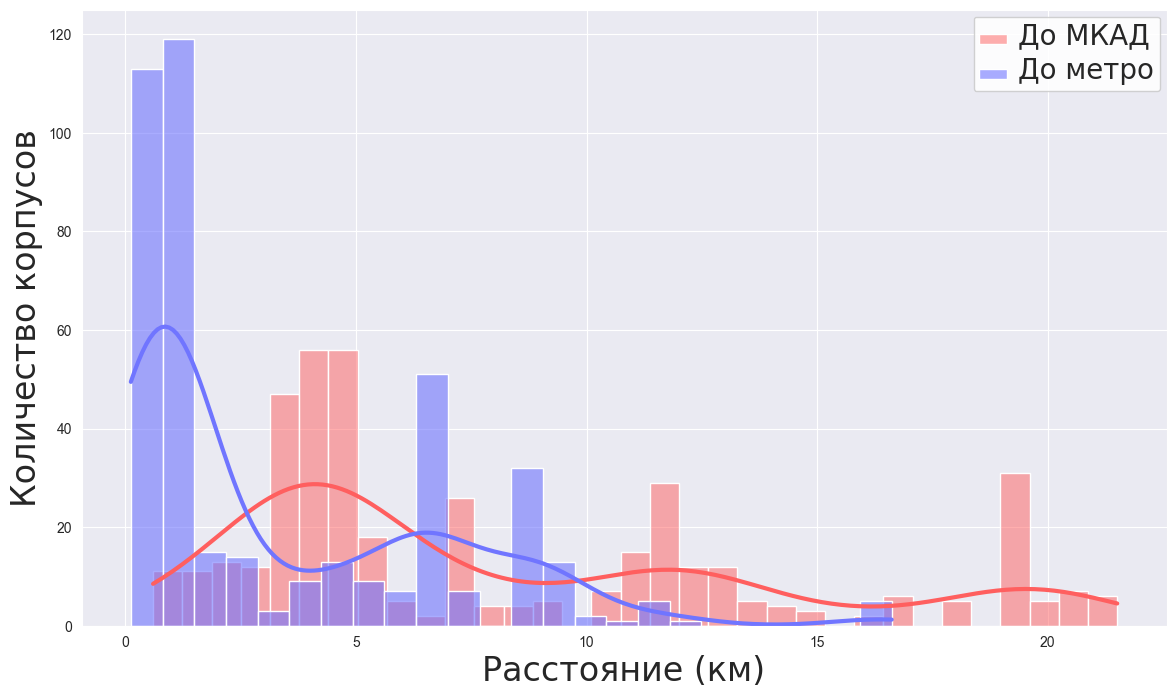

MKAD
Медиана: 5.394, Среднее: 8.171422434367543, Ст. отклонение: 5.777037988381971
METRO
Медиана: 1.276, Среднее: 3.358109785202864, Ст. отклонение: 3.5184930634689535


In [304]:
data_mkad = df.groupby(['ID корпуса'])['Расстояние до МКАД'].mean().dropna()
data_metro = df.groupby(['ID корпуса'])['Расстояние до станции метро'].mean().dropna()

plt.figure(figsize=(14, 8))

sns.histplot(
    x=data_mkad, 
    bins=33, 
    color='#FF5F5F',     
    edgecolor='white',
    alpha=0.5,           
    kde=True,            
    line_kws={'linewidth': 3},
    label='До МКАД'      
)

sns.histplot(
    x=data_metro, 
    bins=24, 
    color='#7075FF',     
    edgecolor='white',
    alpha=0.6,           
    kde=True,
    line_kws={'linewidth': 3},
    label='До метро'
)

plt.xlabel('Расстояние (км)', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество корпусов', fontproperties=font_prop, fontsize=24)

legend = plt.legend(frameon=True, facecolor='white', framealpha=0.9, loc='upper right')
for text in legend.get_texts():
    text.set_fontproperties(font_prop)
    text.set_fontsize(20)

plt.savefig('../graphs/mkad_vs_metro_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print('MKAD')
print_stats(data_mkad)
print('METRO')
print_stats(data_metro)

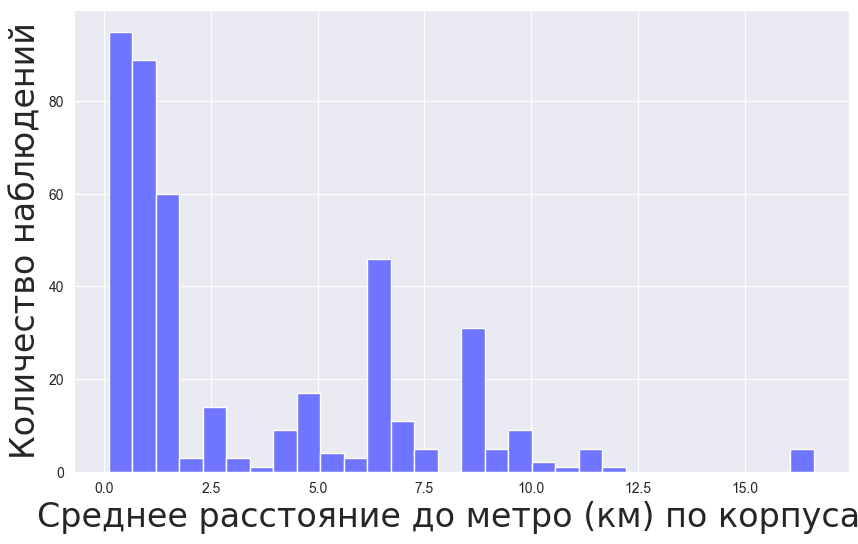

Медиана: 1.276, Среднее: 3.358109785202864, Ст. отклонение: 3.5184930634689535


In [305]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['Расстояние до станции метро'].mean().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=30,
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Среднее расстояние до метро (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/metro_dist_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

## ФИЛЬТРАЦИЯ

In [306]:
print(len(df.groupby(['ID корпуса'])))

419


In [307]:
print('Before:', len(df))
df = filter(df, ~np.isnan(df['Плановая дата РВЭ'])) # Удалим один NaN
df = filter(df, df['Плановая дата РВЭ'] <= datetime.datetime(2025, 11, 1)) # Удаляем еще не сданные дома
print('After:', len(df))

Before: 49494
0.9999797955307714
0.5120724142808074
After: 25344


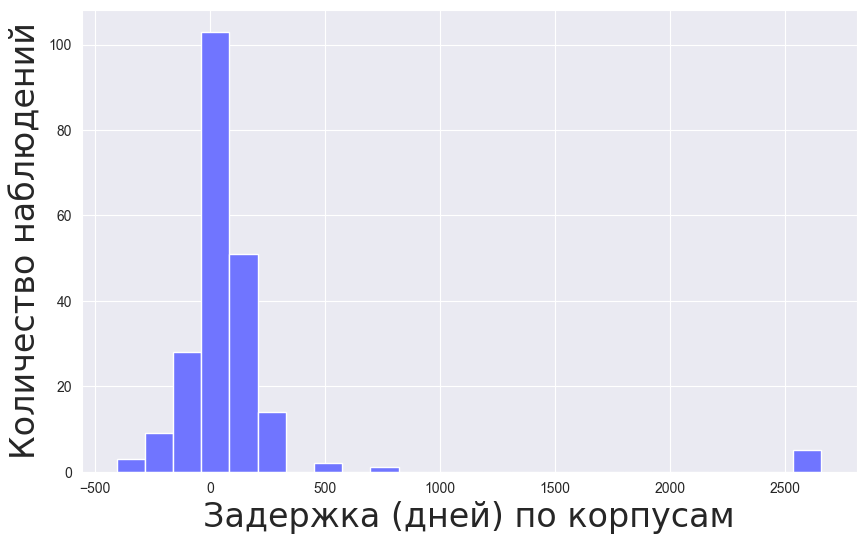

Медиана: 41.0, Среднее: 108.21296296296296, Ст. отклонение: 409.231135029694


In [308]:
plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['Задержка в днях'].median().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Задержка (дней) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/delay_days_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

In [309]:
df = filter(df, df['Расстояние до МКАД'] < 19)
print('After:', len(df))

0.9300820707070707
After: 23572


In [310]:
print(len(df.groupby(['ID корпуса'])))

179


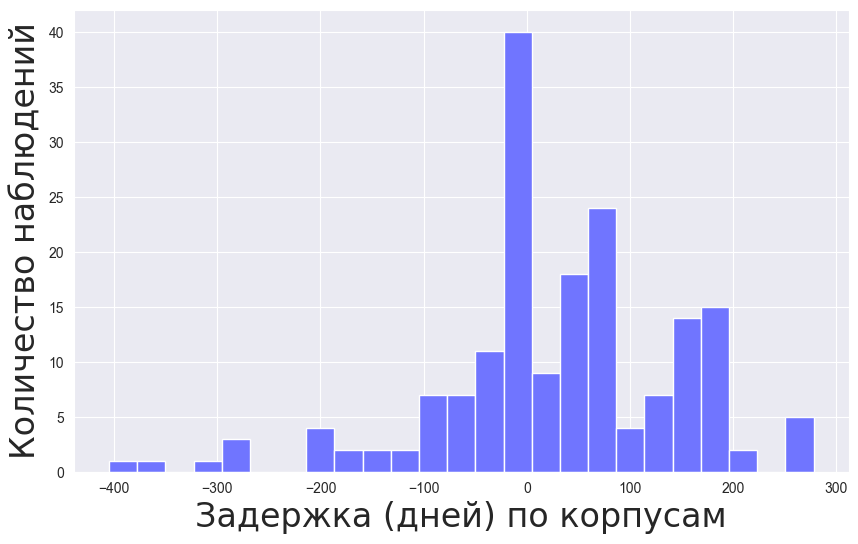

Медиана: 32.0, Среднее: 30.966480446927374, Ст. отклонение: 115.95446120082924


In [311]:
plt.figure(figsize=(10, 6))

x_data = df.groupby(['ID корпуса'])['Задержка в днях'].median().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Задержка (дней) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/delay_days_distribution_filtered.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

In [312]:
import plotly.graph_objects as go
import plotly.io as pio


x_data = df['Задержка в днях'].dropna()

fig = go.Figure()

fig.add_trace(go.Box(
    x=x_data,
    name='',              
    orientation='h',      
    
    line=dict(color='#7075FF', width=2),
    fillcolor='rgba(112, 117, 255, 0.5)',
    
    boxpoints='outliers', 
    marker=dict(
        color='#555555',
        size=6,
        opacity=0.6,
        symbol='circle'
    )
))

fig.update_layout(
    xaxis_title='Задержка (дней)',
    xaxis=dict(
        showgrid=True,
        gridcolor='#dddddd',
        
        zeroline=True,
        zerolinecolor='#dddddd',
        zerolinewidth=1,
        
        title_font=dict(size=24, family=font_name),
        tickfont=dict(size=18, family=font_name)
    ),
    yaxis=dict(
        showgrid=False,
        showticklabels=False
    ),
    paper_bgcolor='rgba(0,0,0,0)', 
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000, 
    height=600,
    font=dict(family=font_name),
    margin=dict(l=20, r=20, t=20, b=20)
)

try:
    # 4. Сохранение
    fig.write_image("../graphs/delay_days_boxplot_plotly.png", scale=3)
    fig.show()
except Exception as e:
    print(f'Error: {e}')
    print("УВЫ")

Error: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

УВЫ


In [313]:
def plot_corr_style_template(corr_matrix,
                             feature_names,
                             outpath='../graphs/heatmap_corr.png',
                             figsize=(10, 8),
                             cmap=None,
                             vmin=-1, 
                             vmax=1):
    if cmap is None:
        cmap = sns.color_palette("blend:#ff5f5f,#FFFFFF,#434afa", as_cmap=True)
    
    plt.figure(figsize=figsize)
    
    ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cbar=False,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        xticklabels=feature_names,
        yticklabels=feature_names,
        linewidths=10,
        linecolor="#F6F6F6",
        square=True,
        cbar_kws={"shrink": 0.7, "pad": 0.03}
    )

    for text in ax.texts:
        try:
            text.set_fontproperties(font_prop)
        except NameError:
            pass
        text.set_fontsize(32)
        text.set_weight('medium')

    ax.set_xlabel('')
    ax.set_ylabel('')

    for tl in ax.get_xticklabels():
        try:
            tl.set_fontproperties(font_prop)
        except NameError:
            pass
        tl.set_rotation(0)
        tl.set_fontsize(20)
        
    for tl in ax.get_yticklabels():
        try:
            tl.set_fontproperties(font_prop)
        except NameError:
            pass
        tl.set_rotation(0)
        tl.set_fontsize(20)


    plt.tight_layout()
    plt.savefig(outpath, dpi=300, transparent=True, bbox_inches='tight')
    plt.show()

cols_to_corr = [
    'Задержка в днях', 
    'Цена квадратного метра',
    'Расстояние до МКАД', 
    'Расстояние до станции метро', 
    'Этажей до'
]

cols_to_corr_names = [
    'Задержка (дни)', 
    'Цена м²',
    'Расстояние\nдо МКАД', 
    'Расстояние\nдо метро', 
    'Этажей'
]

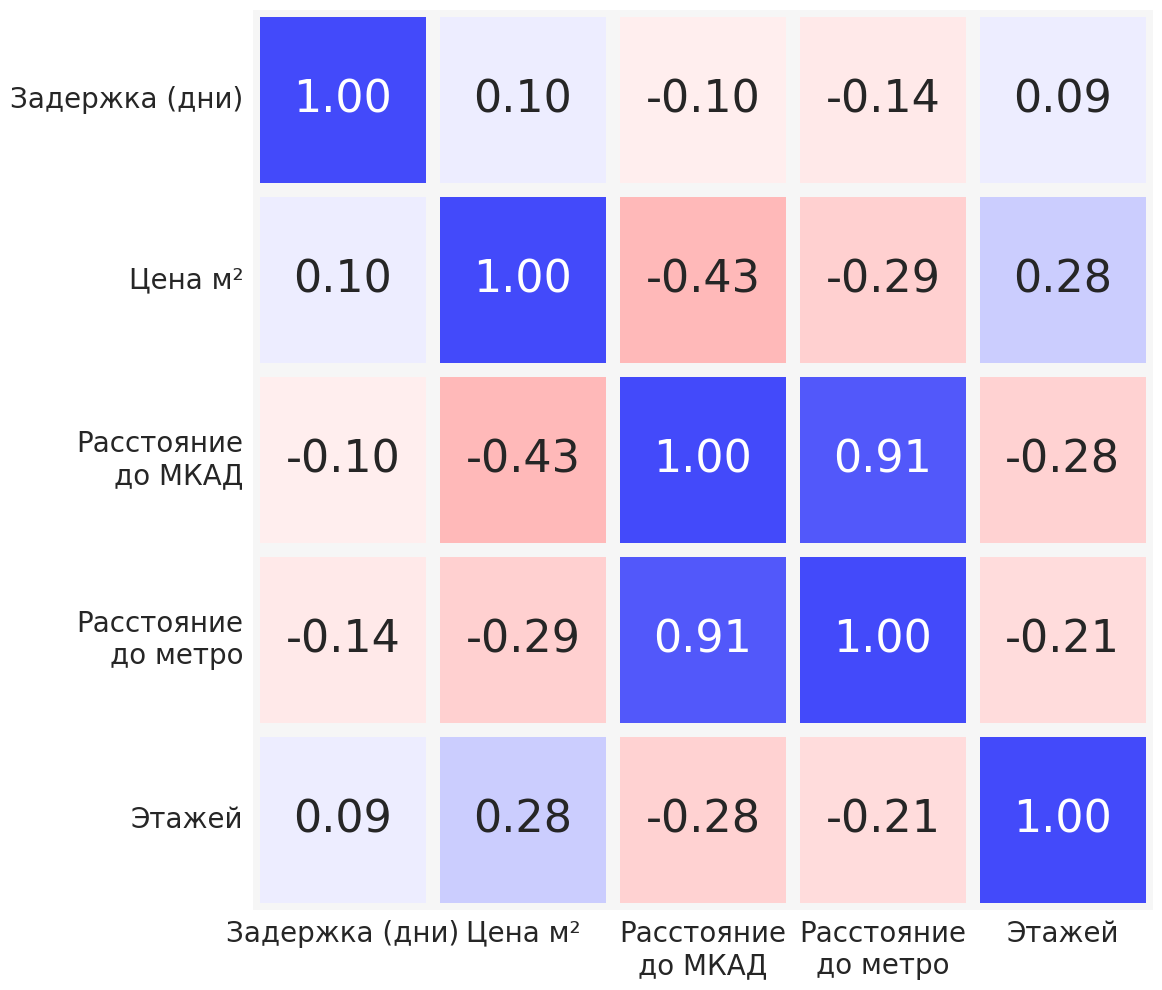

In [314]:
plot_corr_style_template(
    corr_matrix=df.groupby('ID корпуса')[cols_to_corr].mean().corr(), 
    feature_names=cols_to_corr_names,
    outpath='../graphs/correlation_matrix.png',
    figsize=(12, 10)
)

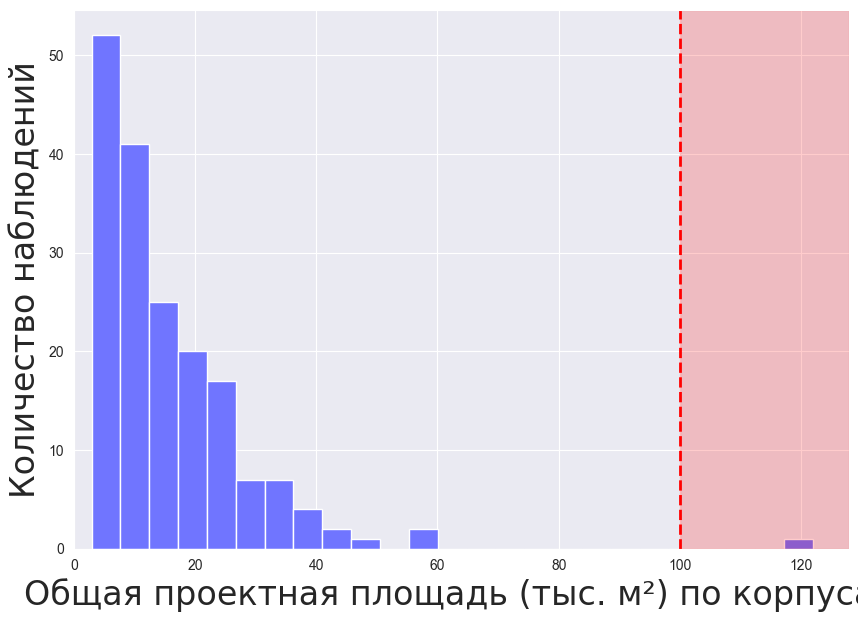

Медиана: 11.4595, Среднее: 15.831122011173186, Ст. отклонение: 13.21288813081036


In [315]:
plt.figure(figsize=(10, 7))

data = df.groupby('ID корпуса')['Общая проектная площадь'].mean().dropna() / 1000

ax = sns.histplot(
    x=data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

current_right_limit = ax.get_xlim()[1]

ax.axvline(x=100, color='red', linestyle='--', linewidth=2)

ax.axvspan(xmin=100, xmax=current_right_limit, color='red', alpha=0.2)

ax.set_xlim(left=0, right=current_right_limit)

plt.xlabel('Общая проектная площадь (тыс. м²) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)
plt.savefig('../graphs/total_project_area_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(data)

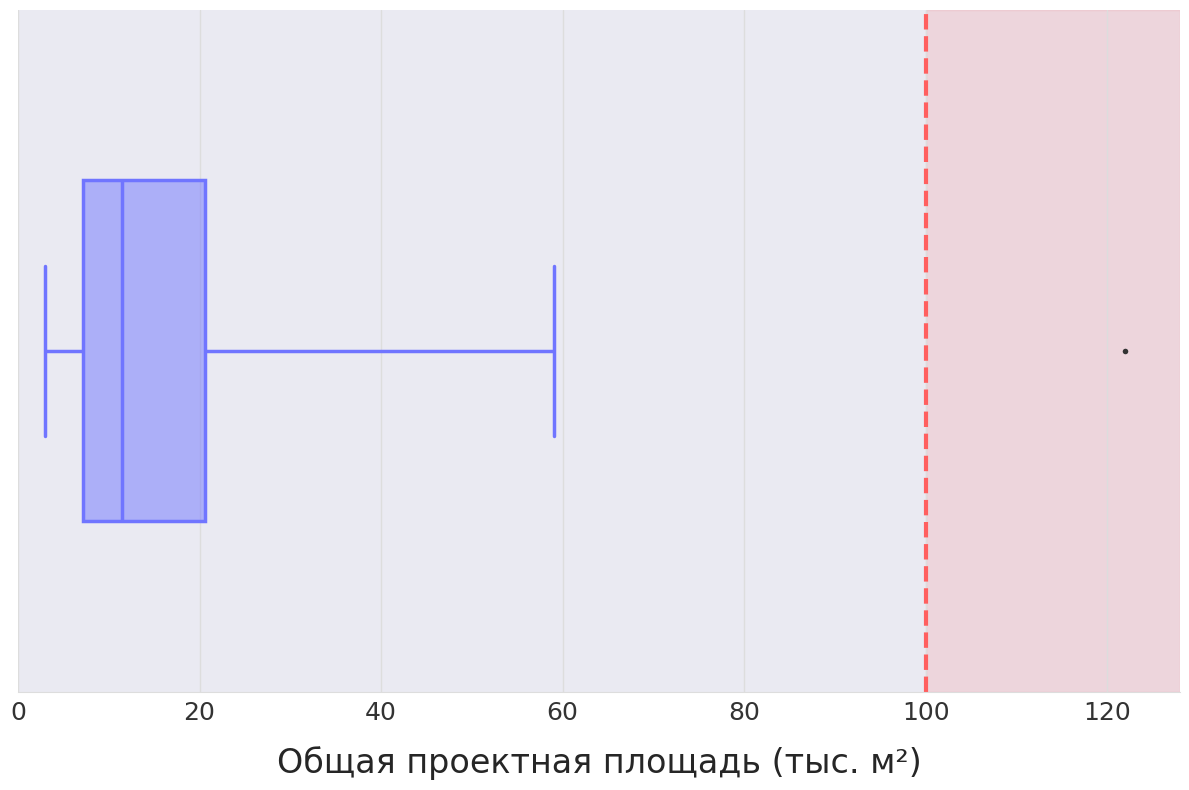

Статистика: Общая проектная площадь (тыс. м²)
Медиана: 11.4595, Среднее: 15.831122011173186, Ст. отклонение: 13.21288813081036


In [316]:
x_data = df.groupby('ID корпуса')['Общая проектная площадь'].mean().dropna() / 1000
max_val = x_data.max() * 1.05

plt.figure(figsize=(12, 8))

box_facecolor = (112/255, 117/255, 255/255, 0.5)
line_color = '#7075FF'

flier_props = dict(
    marker='o', 
    markerfacecolor='#333333', 
    markersize=4,
    linestyle='none', 
    markeredgecolor='none', 
    alpha=1
)

median_props = dict(linestyle='-', linewidth=2.5, color=line_color)

ax = sns.boxplot(
    x=x_data, 
    whis=3,
    flierprops=flier_props,
    boxprops=dict(facecolor=box_facecolor, edgecolor=line_color, linewidth=2.5),
    medianprops=median_props,
    whiskerprops=dict(color=line_color, linewidth=2.5),
    capprops=dict(color=line_color, linewidth=2.5),
    width=0.5
)

ax.axvline(x=100, color='#ff5f5f', linestyle='--', linewidth=3)
ax.axvspan(xmin=100, xmax=max_val, color='#ff5f5f', alpha=0.15, zorder=0)

ax.set_xlim(left=0, right=max_val)
ax.xaxis.grid(True, color='#dddddd', linestyle='-', linewidth=1)
ax.yaxis.grid(False)

sns.despine(left=True, bottom=False) 
ax.spines['bottom'].set_color('#dddddd')

plt.xlabel('Общая проектная площадь (тыс. м²)', fontproperties=font_prop, fontsize=24, labelpad=15)
plt.ylabel('', fontproperties=font_prop, fontsize=24)

for label in ax.get_xticklabels():
    label.set_fontproperties(font_prop)
    label.set_fontsize(18)
    label.set_color('#333333')

ax.set_yticks([])

plt.tight_layout()
plt.savefig('../graphs/total_project_area_boxplot.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print("Статистика: Общая проектная площадь (тыс. м²)")
print_stats(x_data)

In [317]:
len(df), len(df.groupby('ID корпуса'))

(23572, 179)

ФИЛЬТР (ПОСЛЕДНИЙ)

In [318]:
df = filter(df, df['Общая проектная площадь'] <= 100_000)

print('After:', len(df))
print_stats(df.groupby('ID корпуса')['Общая проектная площадь'].mean().dropna() / 1000)

0.9577464788732394
After: 22576
Медиана: 11.420350000000001, Среднее: 15.23522943820225, Ст. отклонение: 10.566309570783197


In [319]:
len(df), len(df.groupby('ID корпуса'))

(22576, 178)

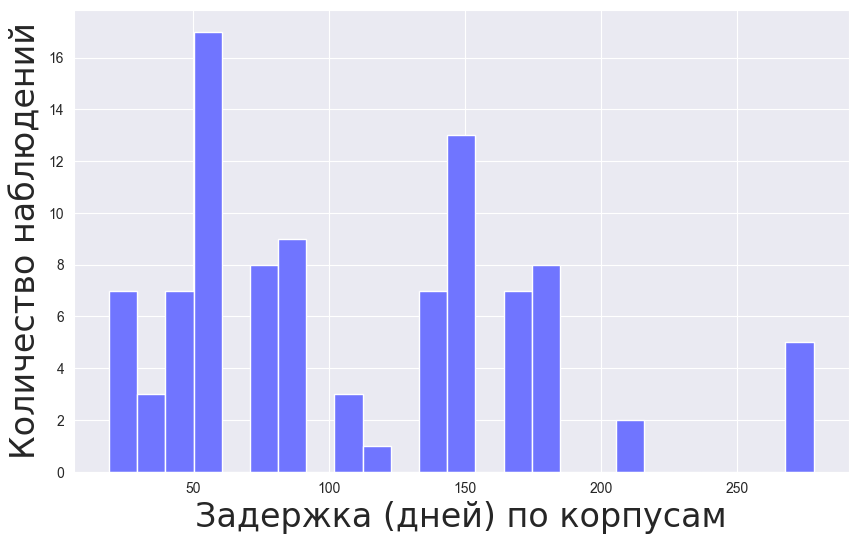

Медиана: 86.0, Среднее: 109.88659793814433, Ст. отклонение: 65.92070304044913


In [320]:
plt.figure(figsize=(10, 6))

x_data = df[df['Задержка в днях'] > 0].groupby(['ID корпуса'])['Задержка в днях'].median().dropna()

ax = sns.histplot(
    x=x_data, 
    bins=25, 
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

plt.xlabel('Задержка (дней) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/delay_days_distribution_filtered_only_plus.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(x_data)

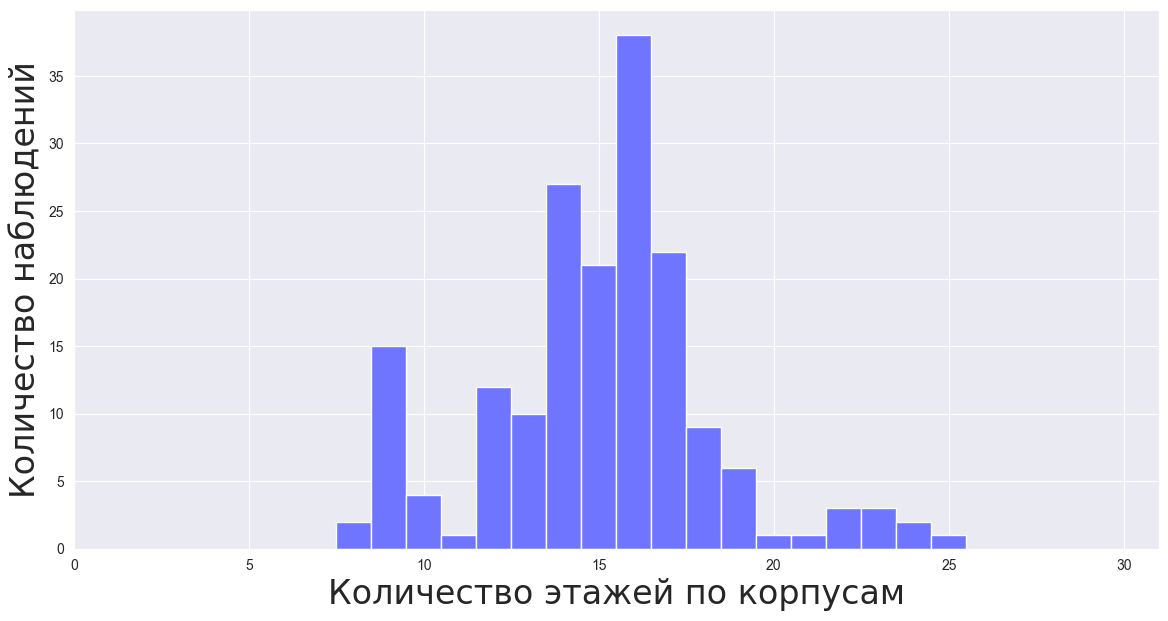

Медиана: 15.0, Среднее: 15.03370786516854, Ст. отклонение: 3.270997146476006


In [321]:
plt.figure(figsize=(14, 7))

data = df.groupby('ID корпуса')['Этажей до'].mean().dropna()

ax = sns.histplot(
    x=data, 
    discrete=True,
    color='#7075FF', 
    edgecolor='white',
    alpha=1
)

ax.set_xlim(left=0, right=31)

plt.xlabel('Количество этажей по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Количество наблюдений', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/floors_distribution.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

print_stats(data)

In [322]:
df[(df['Расстояние до МКАД'] < 2)].groupby(['Чистый адрес']).first()

,Название региона,Город,Район,Округ,Класс,Конструкция объекта,Застройщик,Название ЖК,Адрес корпуса,ID корпуса,...,Цена квадратного метра,Дней после начала продаж,Дней до ввода в эксплуатацию,Дней между началом продаж и вводом в эксплуатацию,Задержка в днях,Задержка,Сдача в срок,Ранняя сдача,Площадь квартиры,Доля уступок
Чистый адрес,,,,,,,,,,,,,,,,,,,,,
"Москва, Дудкино деревня , корпус 1.1",Новая Москва,Дудкино дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 1.1",9964f9e521f9f8637c81e8bbca7230e4,...,221118.990826,585,89,674,82.0,True,False,False,43.60,6.919431
"Москва, Дудкино деревня , корпус 1.2",Новая Москва,дер. Дудкино,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 1.2",3eb2ffd2d5b86ebece924c8ac9a762fc,...,359578.539854,548,89,637,82.0,True,False,False,23.21,6.919431
"Москва, Дудкино деревня , корпус 1.3",Новая Москва,Дудкино дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 1.3",058fdcbb0875687e8a31f0e526e4a00d,...,187409.997433,487,89,576,82.0,True,False,False,77.92,6.919431
"Москва, Дудкино деревня , корпус 2.1",Новая Москва,Дудкино дер.,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 2.1",30a4c760a7c61fb1b7e1ccc764db76e1,...,289914.813815,284,546,830,268.0,True,False,False,37.06,6.919431
"Москва, Дудкино деревня , корпус 2.4",Новая Москва,дер. Дудкино,НАО,Коммунарка,Комфорт,Монолит-блоки,Самолет,Тропарево Парк,"Дудкино дер., к. 2.4",55d730f977631ed10d5059427d02ecf7,...,237749.569948,334,546,880,268.0,True,False,False,55.97,6.919431
"Москва, Сосенское поселение , дом 35, корпус 35.1.1",Новая Москва,Коммунарка п.,НАО,Коммунарка,Комфорт,Монолит-блоки,А101,Скандинавия,"Сосенское пос., д. 35, к. 35.1.1",2ea6f72896f591f29f6dafd5f7ccbc2d,...,307367.960688,184,730,914,73.0,True,False,False,40.70,1.303215
"Москва, Сосенское поселение , дом 35, корпус 35.2.2",Новая Москва,Коммунарка п.,НАО,Коммунарка,Комфорт,Монолит-блоки,А101,Скандинавия,"Сосенское пос., д. 35, к. 35.2.2",7381cbda8cfc80a10151b1135d17b8cf,...,241025.837743,117,730,847,150.0,True,False,False,56.70,1.303215
"Москва, Сосенское поселение , дом 36, корпус 36.2.2",Новая Москва,Коммунарка п.,НАО,Коммунарка,Комфорт,Монолит-блоки,А101,Скандинавия,"Сосенское пос., д. 36, к. 36.2.2",9e1cd728f8c59e284b4205af2b6132d7,...,259994.701195,184,730,914,57.0,True,False,False,50.20,1.303215


In [323]:
import pandas as pd

df_grouped = df.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median()

df_grouped['mkad_dist_km_sq'] = df_grouped['Расстояние до МКАД'] ** 2

X = df_grouped[['Расстояние до МКАД', 'mkad_dist_km_sq']]
y = df_grouped['Задержка в днях']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.839
Date:                Tue, 16 Dec 2025   Prob (F-statistic):            0.00901
Time:                        01:57:23   Log-Likelihood:                -1093.8
No. Observations:                 178   AIC:                             2194.
Df Residuals:                     175   BIC:                             2203.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -28.7719     32

In [324]:
df_grouped = df.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median()

scaler = StandardScaler()

df_grouped['mkad_std'] = scaler.fit_transform(df_grouped[['Расстояние до МКАД']])

df_grouped['mkad_std_sq'] = df_grouped['mkad_std'] ** 2

X = df_grouped[['mkad_std', 'mkad_std_sq']]
y = df_grouped['Задержка в днях']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.839
Date:                Tue, 16 Dec 2025   Prob (F-statistic):            0.00901
Time:                        01:57:23   Log-Likelihood:                -1093.8
No. Observations:                 178   AIC:                             2194.
Df Residuals:                     175   BIC:                             2203.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          58.2619     13.124      4.439      

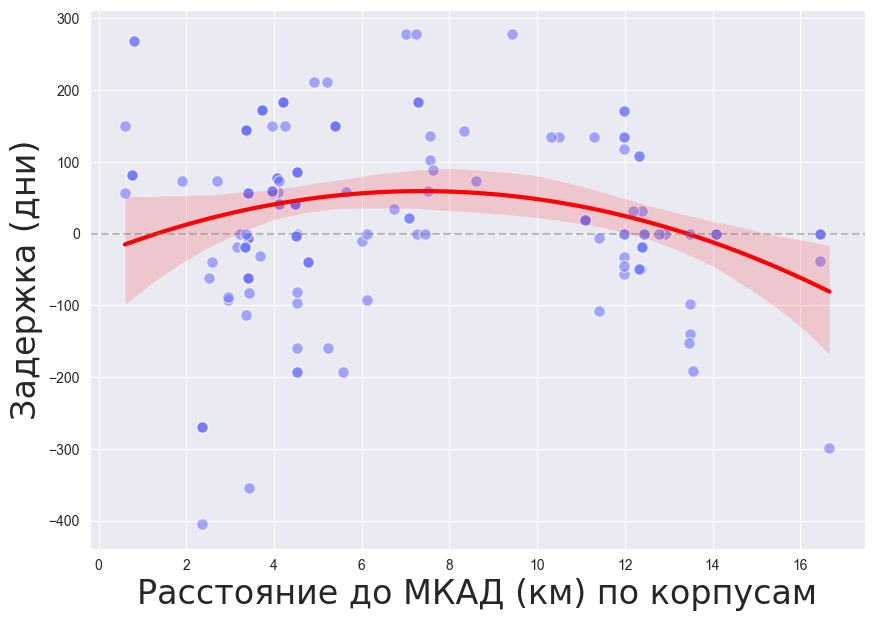

In [325]:
plt.figure(figsize=(10, 7))

sns.regplot(
    data=df.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median(),
    x='Расстояние до МКАД', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Задержка (дни)', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/mkad_dist_vs_delay_regplot.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

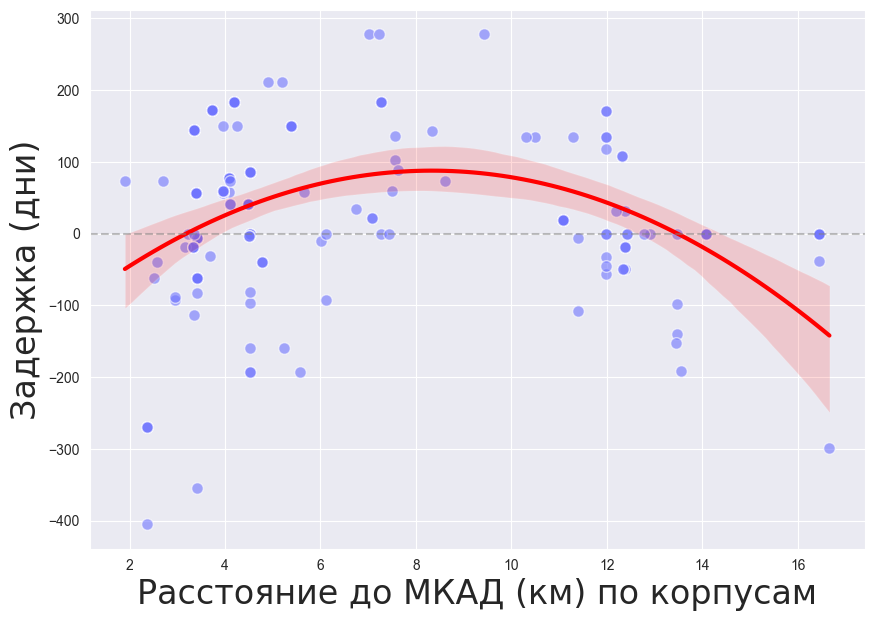

In [326]:
plt.figure(figsize=(10, 7))

sns.regplot(
    data=df[df['Расстояние до МКАД'] > 1].groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median(),
    x='Расстояние до МКАД', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Задержка (дни)', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/mkad_dist_vs_delay_regplot_bolshe1.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

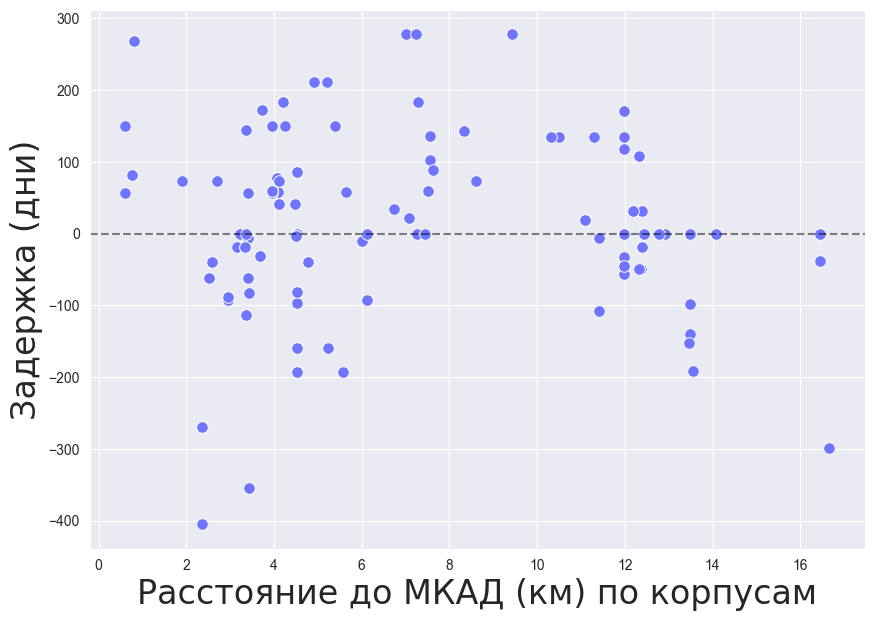

In [327]:
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=df.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median(),
    x='Расстояние до МКАД', 
    y='Задержка в днях', 
    color='#7075FF', edgecolor='white', alpha=1, s=70
)

plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontproperties=font_prop, fontsize=24)
plt.ylabel('Задержка (дни)', fontproperties=font_prop, fontsize=24)

plt.savefig('../graphs/mkad_dist_vs_delay_scatterplot.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Уравнение красной линии: $y = -1.62x^2 + 23.91x - 28.77$


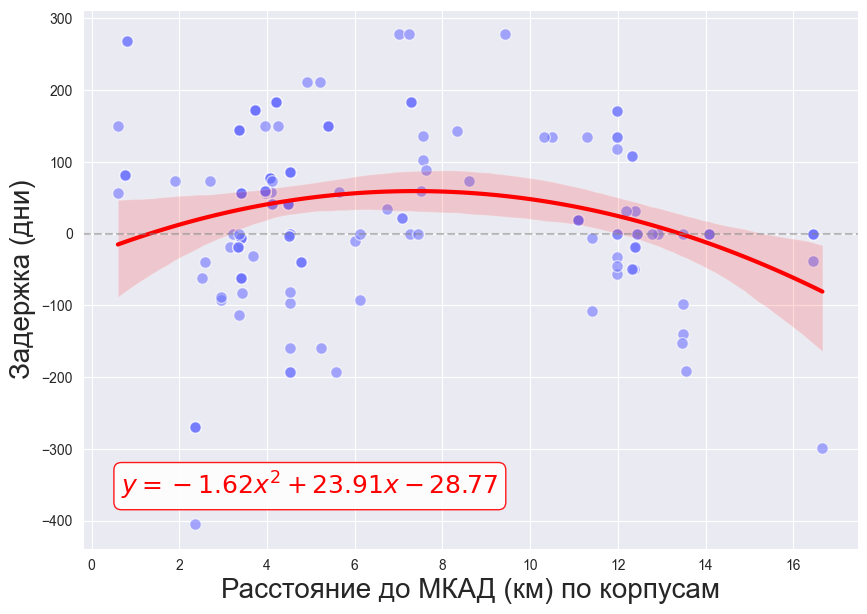

In [328]:
df_agg = df.groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median().dropna()

x = df_agg['Расстояние до МКАД']
y = df_agg['Задержка в днях']

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

sign_b = "+" if z[1] >= 0 else "-"
sign_c = "+" if z[2] >= 0 else "-"
eq_text = f"$y = {z[0]:.2f}x^2 {sign_b} {abs(z[1]):.2f}x {sign_c} {abs(z[2]):.2f}$"

print("Уравнение красной линии:", eq_text)

plt.figure(figsize=(10, 7))

sns.regplot(
    data=df_agg,
    x='Расстояние до МКАД', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.text(0.05, 0.1, eq_text, transform=plt.gca().transAxes, 
         fontsize=18, color='red', weight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontsize=20)
plt.ylabel('Задержка (дни)', fontsize=20)

plt.grid(True)
plt.savefig('../graphs/mkad_dist_vs_delay_regplot_eq.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Уравнение красной линии: $y = -3.31x^2 + 55.22x - 142.33$


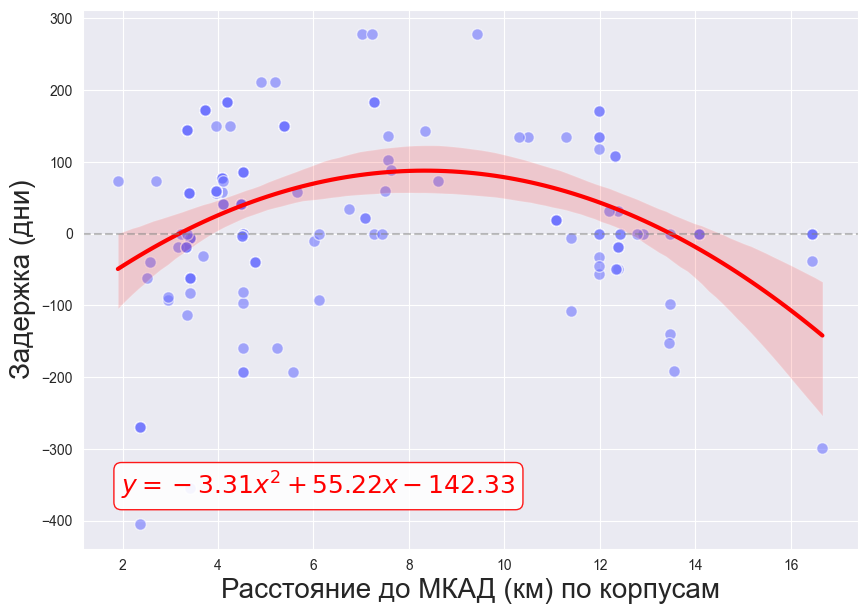

In [329]:
df_agg = df[df['Расстояние до МКАД'] > 1].groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median().dropna()

x = df_agg['Расстояние до МКАД']
y = df_agg['Задержка в днях']

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

sign_b = "+" if z[1] >= 0 else "-"
sign_c = "+" if z[2] >= 0 else "-"
eq_text = f"$y = {z[0]:.2f}x^2 {sign_b} {abs(z[1]):.2f}x {sign_c} {abs(z[2]):.2f}$"

print("Уравнение красной линии:", eq_text)

plt.figure(figsize=(10, 7))

sns.regplot(
    data=df_agg,
    x='Расстояние до МКАД', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.text(0.05, 0.1, eq_text, transform=plt.gca().transAxes, 
         fontsize=18, color='red', weight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontsize=20)
plt.ylabel('Задержка (дни)', fontsize=20)

plt.grid(True)
plt.savefig('../graphs/mkad_dist_vs_delay_regplot_bolshe1_eq.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Уравнение красной линии: $y = -5.46x^2 + 87.41x - 234.69$


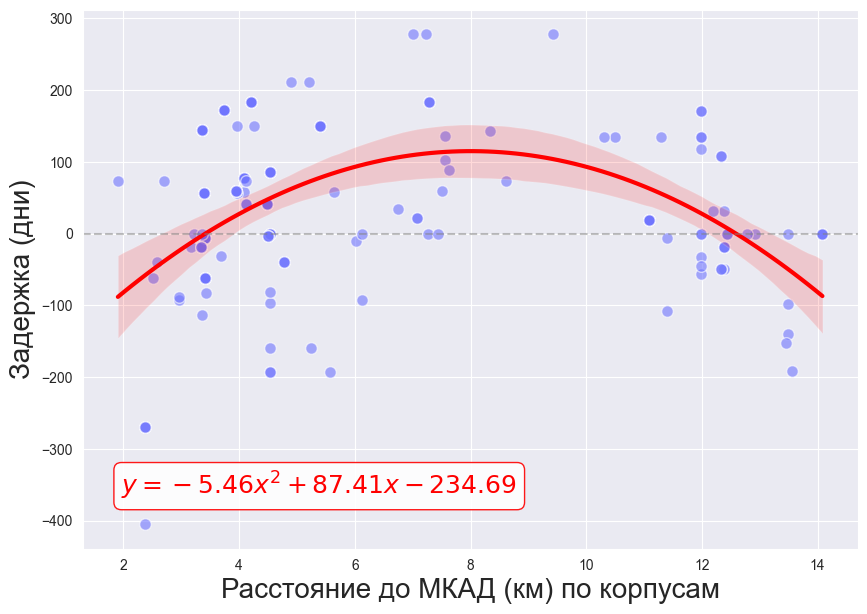

In [330]:
df_agg = df[(df['Расстояние до МКАД'] > 1) & (df['Расстояние до МКАД'] < 16)].groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median().dropna()

x = df_agg['Расстояние до МКАД']
y = df_agg['Задержка в днях']

z = np.polyfit(x, y, 2)
p = np.poly1d(z)

sign_b = "+" if z[1] >= 0 else "-"
sign_c = "+" if z[2] >= 0 else "-"
eq_text = f"$y = {z[0]:.2f}x^2 {sign_b} {abs(z[1]):.2f}x {sign_c} {abs(z[2]):.2f}$"

print("Уравнение красной линии:", eq_text)

plt.figure(figsize=(10, 7))

sns.regplot(
    data=df_agg,
    x='Расстояние до МКАД', 
    y='Задержка в днях', 
    order=2,
    scatter_kws={'color': '#7075FF', 'edgecolor': 'white', 'alpha': 0.6, 's': 70},
    line_kws={'color': 'red', 'linewidth': 3}
)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

plt.text(0.05, 0.1, eq_text, transform=plt.gca().transAxes, 
         fontsize=18, color='red', weight='bold', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9))

plt.xlabel('Расстояние до МКАД (км) по корпусам', fontsize=20)
plt.ylabel('Задержка (дни)', fontsize=20)

plt.grid(True)
plt.savefig('../graphs/mkad_dist_vs_delay_regplot_bolshe1_menshe16_eq.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [331]:
a = len(df[(df['Расстояние до МКАД'] > 1) & (df['Расстояние до МКАД'] < 16)].groupby(['ID корпуса']))
n = len(df.groupby(['ID корпуса']))

(n - a) / n, a, n

(0.07303370786516854, 165, 178)

In [332]:
df_grouped = df[(df['Расстояние до МКАД'] > 1) & (df['Расстояние до МКАД'] < 16)].groupby(['ID корпуса'])[['Расстояние до МКАД', 'Задержка в днях']].median()

df_grouped['mkad_dist_km_sq'] = df_grouped['Расстояние до МКАД'] ** 2

X = df_grouped[['Расстояние до МКАД', 'mkad_dist_km_sq']]
y = df_grouped['Задержка в днях']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Задержка в днях   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     15.90
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           4.95e-07
Time:                        01:57:25   Log-Likelihood:                -1000.6
No. Observations:                 165   AIC:                             2007.
Df Residuals:                     162   BIC:                             2016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -234.6927     49